**This Notebook does a simple linear regression of star count on data from Libraries.io** 

- first it reads in the data and generates dummies
- A lasso regression is used to find valuable features
- OLS is run on the features found by the lasso, from this a second filtering of features is done based on pvalues
- Finally running the another OLS regression using the final features and storing it so it can be used for prediction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
import time
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce
from sklearn import preprocessing
import math

pd.set_option('display.max_columns', 500)

In [2]:
N_SAMPLES = 500000
VERBOSE = True
ALPHA = [0.00001,0.0001,0.001,0.01,0.1]
P_CUTOFF = 0.2
TESTING = True
PATH ="../data/repositories-1.4.0-2018-12-22-rating.csv"

In [19]:
#Functions for factorizing and getting dummies
def gnumeric_func (data, columns):
    data[columns] = data[columns].apply(lambda x: pd.factorize(x)[0])
    return data

def getDummies (data, feature):
    dummies = pd.get_dummies(data[feature])
    data = pd.concat([data, dummies], axis=1)
    data = data.drop([feature],axis=1)
    return data

def convertDateTime(data):
    data[['Created Timestamp', 'Updated Timestamp']] = data[['Created Timestamp', 'Updated Timestamp']].apply(pd.to_datetime)
    data['fulltime'] = (max(data['Updated Timestamp']) - data['Created Timestamp'])
    data['fulltime'] = data['fulltime'].apply(lambda x: x.days)
    return data

def getDatax(data, datay):
    droplist = ['Rating','ID','fulltime','SourceRank','Description', 'Name with Owner', 'Created Timestamp', "Updated Timestamp", 'Last pushed Timestamp', 'Homepage URL', 'Mirror URL', 'UUID', 'Last Synced Timestamp','Fork Source Name with Owner', 'Changelog filename', 'Contributing guidelines filename', 'License filename','Code of Conduct filename', 'Security Threat Model filename', 'Security Audit filename', 'SCM type', 'Logo URL', 'Keywords', 'Stars Count' ]
    factorizelist = ['Default branch', 'Display Name', 'Pull requests enabled'] 
    truefalselist = ['Fork', 'Issues enabled', 'Wiki enabled', 'Pages enabled']
    dummieslist = ['Status','Host Type']
    binaryEncodelist = ['Language', 'License']

    datax = data.drop(droplist, axis=1)
    datax = datax.drop(['Readme filename'], axis=1) #idk why I need to do it separately, needs cleaning

    datax = gnumeric_func(datax, factorizelist)
    datax[truefalselist] = datax[truefalselist] * 1

    for item in dummieslist:
        datax = getDummies(datax,item)
    
    encoder = ce.BinaryEncoder(cols=binaryEncodelist, verbose=False)
    encoder.fit(datax,datay)
    datax = encoder.transform(datax)
        
    return datax

def normalize(data, sigma, mu):
    data = ((data - mu) / sigma)
    return data

def runOLS(featureList, target, printoutput = True):

    dataxStats = datax[featureList]
    statsmodel = sm.OLS(target, dataxStats.astype(float)).fit()
    if printoutput:
        print(statsmodel.summary())
    return statsmodel



In [4]:
# creating dumies (IMPROVED RECIPE: NOW CONTAINS BINARY ENODING INSTEAD OF ONE HOT ENCODING!)
data = pd.read_csv(PATH, nrows=N_SAMPLES)
data = convertDateTime(data)

/home/rick/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16,31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Language_0,Language_1,Language_2,Language_3,Language_4,Language_5,Language_6,Language_7,Language_8,License_0,License_1,License_2,License_3,License_4,License_5,License_6,Fork,Size,Issues enabled,Wiki enabled,Pages enabled,Forks Count,Open Issues Count,Default branch,Watchers Count,Contributors Count,Display Name,Pull requests enabled,Deprecated,Help Wanted,GitHub
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,512,1,1,1,0,1,0,2.0,1,0,-1,0,0,1
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,924,1,1,0,797,85,0,62.0,21,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,472,0,1,0,0,0,0,1.0,5,0,-1,0,0,1
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,536,1,1,1,1,2,0,1.0,1,0,-1,0,0,1
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,771,1,0,1,0,0,0,14.0,1,0,0,0,0,1


In [48]:
#datay = np.array(data['Stars Count']/data['fulltime']).reshape(-1,1)
datay = np.array(data['Stars Count']).reshape(-1,1)
datax = getDatax(data,datay)

In [49]:
# Create train/test split and THEN normalize data
X_train, X_test, y_train, y_test = train_test_split(datax, datay)

y_test_not_norm = y_test

sigmay = y_train.std()
muy = y_train.mean()

sigmax = X_train[['Size', 'Forks Count', 'Open Issues Count', 'Watchers Count', 'Contributors Count']].std()
mux = X_train[['Size', 'Forks Count', 'Open Issues Count', 'Watchers Count', 'Contributors Count']].mean()

y_train = normalize(y_train, sigma=sigmay, mu = muy)
y_test = normalize(y_test, sigma=sigmay, mu=muy)

X_train[['Size', 'Forks Count', 'Open Issues Count', 'Watchers Count', 'Contributors Count']] = normalize(X_train[['Size', 'Forks Count', 'Open Issues Count', 'Watchers Count', 'Contributors Count']], sigmax, mux)
X_test[['Size', 'Forks Count', 'Open Issues Count', 'Watchers Count', 'Contributors Count']] = normalize(X_test[['Size', 'Forks Count', 'Open Issues Count', 'Watchers Count', 'Contributors Count']], sigmax, mux)

print(len(X_train))
print(len(y_train))

/home/rick/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


375000
375000


alpha =  1e-05
Training score: 0.7564284585099633
Test score:  0.7421655335857309
Number of features used:  24
 
alpha =  0.0001
Training score: 0.7564141477946364
Test score:  0.74219316407886
Number of features used:  22
 
alpha =  0.001
Training score: 0.7562464466098437
Test score:  0.7421800914730646
Number of features used:  17
 
alpha =  0.01
Training score: 0.7547920756240794
Test score:  0.7408466229392239
Number of features used:  6
 
alpha =  0.1
Training score: 0.7390044407266184
Test score:  0.7263062605602282
Number of features used:  4
 
Optimal alpha =  0.0001


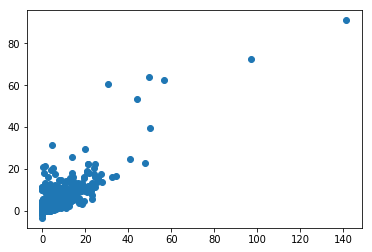

Mean squared error:  0.19591112501474342
Model R² score:  0.7421931640788599


In [50]:
## trying different alphas and choosing the optimal model

# if fitting of the model is really slow, you can drop last values of alpha to make it faster
alphas = ALPHA
n = len(alphas)
test_scores = np.zeros(n)

for i in range(0,n):
    a = alphas[i]
    lasso = Lasso(alpha = a, max_iter = 10e5)
    lasso.fit(X_train, y_train)
    train_score=lasso.score(X_train,y_train)
    test_score=lasso.score(X_test,y_test)
    test_scores[i] = test_score
    coeff_used = np.sum(lasso.coef_!=0)
    
    if VERBOSE:
        print("alpha = ", a)
        print("Training score:", train_score)
        print("Test score: ", test_score)
        print("Number of features used: ", coeff_used)
        print(" ")

# pick the alpha value with best score
best_alpha = alphas[np.argmax(test_scores)]
lasso = Lasso(alpha = best_alpha, max_iter = 10e5)
lasso.fit(X_train, y_train)

# create a dataframe with the coefficents of the features,
# then create a list of the features selected to use in OLS
df_coef = pd.DataFrame({'Features':X_train.columns,'coeff': lasso.coef_})
df_coef = df_coef.sort_values(by = ['coeff'])
df_coef = df_coef[df_coef.coeff != -0.0]
featureList = list(df_coef.Features)
    
# model summary
predicted = lasso.predict(X_test)
expected = y_test
# expected vs predicted values
if VERBOSE:
    print("Optimal alpha = ", best_alpha)
    plt.scatter(expected, predicted)
    plt.show()
    print("Mean squared error: ", mean_squared_error(expected, predicted))
    print("Model R² score: ", r2_score(expected, predicted))

In [11]:
# running the OLS, second selection of features based on pvals and rerun.
pvals = runOLS(featureList=featureList, target=datay, printoutput=False).pvalues

# selecting features based on the cutoff point for the p values
keylist_second = list(dict(pvals[pvals < P_CUTOFF]).keys())

# generating final model
final_model = runOLS(keylist_second, datay)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                 6.716e+04
Date:                Tue, 23 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:09:40   Log-Likelihood:            -3.7073e+06
No. Observations:              500000   AIC:                         7.415e+06
Df Residuals:                  499977   BIC:                         7.415e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Language_1              -58.81

In [51]:
df_coef

,Features,coeff
13,License_4,-0.048479
14,License_5,-0.033658
1,Language_1,-0.031675
4,Language_4,-0.029597
5,Language_5,-0.028883
17,Size,-0.019533
8,Language_8,-0.018208
19,Wiki enabled,-0.017978
6,Language_6,-0.012048
7,Language_7,-0.007174


In [55]:
# TODO: round predictions to full numbers AND [< 0 == 0]

# testing our predictions
print("Predicted ", (lasso.predict(X_test[:10]) * sigmay) + muy)

#print(y_test[:10] * sigmay + muy)

print("Real values ",y_test_not_norm[:10])


Predicted  [ -1.37087353  -1.72418623 -36.78514249 -29.7262411  -29.92647922
 226.0460302   -2.67477207  19.70582733  10.41118527  -8.90602583]
Real values  [[ 14]
 [  1]
 [  2]
 [  1]
 [  0]
 [299]
 [  2]
 [ 33]
 [ 33]
 [  6]]


In [ ]:
# Save model to pickle
if TESTING == False:
    pickle.dump(lasso_model, open('lasso_pickle', 'wb'))


In [ ]:
pd.DataFrame(final_model.params).index.values